# Résolution du problème du voyageur de commerce avec un algorithme génétique et Cython

LACOSTE Rémi

In [1]:
from math import sqrt, floor
import uuid
import random as rd
import copy
import sys
import numpy as np
import pylab as plt
from matplotlib import collections as mc
import time
import array

# 0. Introduction

Le problème du voyageur du commerce est un problème NP complet où l'objectif est de trouver le chemin le plus court pour relier un ensemble de villes donné.

Pour le résoudre, nous nous proposons d'utiliser un algorithme génétique. Ce type d'algorithme s'inspire de la théorie de l'évolution des espèces pour faire évoluer une population initiale vers une population contenant de "meilleurs" individus.

Dans notre cas, notre population initiale est constituée de chemins aléatoires reliant toutes les villes. On espère ainsi, après Ng générations obtenir une bonne solution à notre problème, si ce n'est la meilleure !

<img src="img/example.png">
<center><i>Exemple d'un parcours (on espère pouvoir faire mieux que ça !)</i></center>

# 1. Explication de l'algorithme

## 1.1. Entités manipulées

<b>Gènes :</b><br>
Les gènes de nos individus sont des villes (classe town) caractérisés notamment par un couple (x,y) définissant leur position dans un espace à 2 dimensions.

<b>Individus/Chromosomes :</b><br>
Nos individus sont des chemins (classe path). Un chemin est caractérisé par un ensemble de villes ordonné. 

<b>Populations :</b><br>
Une population (classe population) est un ensemble de N individus.

## 1.2. Fonctionnement de l'algorithme

### 1.2.1. Aperçu
Notre algorithme est consituté des étapes suivantes :

0. Création d'une population initiale

Puis, pour chaque génération :

1. Evaluation des individus
2. Sélection des individus
3. Création de nouveaux individus
    1. Par emjambement
    2. Par clonage
4. Mutation des individus
5. Préparation de la génération suivante

### 1.2.2. Explications et implémentation

Détaillons un peu plus en profondeur ces étapes et discutons de leur implémentation :

<b>0. Création d'une population initiale</b>

On crée une population de N chemins passant par V villes.
Pour chaque chemin, l'ordre des villes est généré aléatoirement.

<b>1. Evaluation des individus</b>

Dans cette étape, on calcule la longueur de chaque chemin. Cette longueur va nous servir dans l'étape suivante à évaluer la "fitness" (ie. qualité) de l'individu.

<b>2. Sélection des individus</b>

Chaque individu de la population a une probabilité non nulle d'être géniteur d'un individu de la population suivante. Toutefois, meilleur il est (ie. plus sa fitness est élevée), plus il aura de chance d'être retenu.

Dans notre implémentation, la fitness est calculée comme étant l'inverse de la longueur du chemin. Si un individu A a un chemin deux fois plus court qu'un individu B, il a aussi deux fois plus de chance d'être retenu.

<b>3. Création de nouveaux individus</b>

Une fois notre population de géniteurs sélectionnée, celle-ci va créer des enfants de deux façons :
* avec une probabilité 1 - pc (pc = probabilité de croisement), l'enfant est un clone d'un de ses deux parents
* avec une probabilité pc, les chromosomes des deux parents sont croisés pour créer celui de l'enfant.

<b>Exemple de croisement:</b>

Soit V1, V2, V3, V4, V5, V6 les villes de notre problème.

Si le parent 1 a pour chromosome (ie. chemin) :

<table>
    <td>
        V2
    </td>
    <td>
        V4
    </td>
    <td>
        V5
    </td>
    <td>
        V6
    </td>
    <td>
        V1
    </td>
    <td>
        V3
    </td>
</table>

et le parent 2 a pour chromosome :
<table>
    <td>
        V4
    </td>
    <td>
        V1
    </td>
    <td>
        V6
    </td>
    <td>
        V5
    </td>
    <td>
        V2
    </td>
    <td>
        V3
    </td>
</table>

Supposons que la coupure se fassent après la deuxième ville.
Le chromosome de notre enfant débutera avec les deux premières villes du parent 1 :

<table>
    <td>
        V2
    </td>
    <td>
        V4
    </td>
    <td>
        __
    </td>
    <td>
        __
    </td>
    <td>
        __
    </td>
    <td>
        __
    </td>
</table>

On complète quand c'est possible avec la suite du chromosome du parent 2 :
<table>
    <td>
        V2
    </td>
    <td>
        V4
    </td>
    <td>
        V6
    </td>
    <td>
        V5
    </td>
    <td>
        __
    </td>
    <td>
        __
    </td>
</table>

Quand ce n'est pas possible, on passe au gène suivant :
<table>
    <td>
        V2
    </td>
    <td>
        V4
    </td>
    <td>
        V6
    </td>
    <td>
        V5
    </td>
    <td>
        V3
    </td>
    <td>
        __
    </td>
</table>

Lorsqu'on arrive au bout du chromosome du parent 2, on poursuit en rédémarrant la lecture au début de son chromosome :

<table>
    <td>
        V2
    </td>
    <td>
        V4
    </td>
    <td>
        V6
    </td>
    <td>
        V5
    </td>
    <td>
        V3
    </td>
    <td>
        V1
    </td>
</table>

<b>4. Mutation des individus</b>

Une fois notre population d'enfants créée, chaque enfant va avoir une probabilité pm que son chromosome soit l'objet d'une mutation.

<b>Exemple de mutation:</b>

Reprenons l'enfant précédemment créé.

<table>
    <td>
        V2
    </td>
    <td>
        V4
    </td>
    <td>
        V6
    </td>
    <td>
        V5
    </td>
    <td>
        V3
    </td>
    <td>
        V1
    </td>
</table>

On tire au hasard deux entiers entre 1 et 6. Supposons que ce soit 2 et 4. Les allèles de ces deux gènes vont s'inverser pour donner le chromosome suivant :

<table>
    <td>
        V2
    </td>
    <td>
        V5
    </td>
    <td>
        V6
    </td>
    <td>
        V4
    </td>
    <td>
        V3
    </td>
    <td>
        V1
    </td>
</table>

<b>5. Préparation de la génération suivante</b>

Les enfants de la génération G deviennent les parents de la génération G+1

# 2. Algorithme initial

In [2]:
class town:
    """Représente une ville
        id : identifiant de la ville
        x : position selon l'axe des x
        y : position selon l'axe des y
        name : nom de la ville
    """
    
    def __init__(self, x, y, name = None):
        """Input : 
            x : position selon l'axe des x
            y : position selon l'axe des y
            name : nom de la ville
        """
        self.id = str(uuid.uuid4())[0:7]
        self.x = x
        self.y = y
        self.name = name
        
    def __str__(self):
        return "Id : " + self.id + "\n" + \
                "Coordonnées : (" + str(self.x) + ", " + str(self.y) + ")" + "\n" + \
                "Nom de la ville : " + self.name + "\n"
        
    def distance(self, town):
        """Calcule la distance entre deux villes"""
        return sqrt((self.x - town.x)**2 + (self.y - town.y)**2)
    

class path:
    """Représente un parcours ordonné entre plusieurs villes
        id : identifiant
        town_map : liste des villes représentant le parcours
        length : longueur du parcours
    """
    
    def __init__(self, town_list, child = False):
        """Input : 
            town_list : liste des villes parcourues
            child : si child = False, la town_list est mélangée avant d'être assignée à la variable town_map
        """
        self.id = str(uuid.uuid4())[0:13]
        self.town_map = town_list.copy()
        if child == False:
            rd.shuffle(self.town_map)
        self.length = float('nan')
        
    def __str__(self):
        town_map_id = "\n".join([t.id for t in self.town_map])
        town_map_name = "\n".join([t.name for t in self.town_map])
        
        return "-------------------------------------" + "\n" + \
               "Id : " + self.id + "\n\n" + \
               "Parcours des villes (name)" + "\n" + town_map_name + "\n" + \
               "-------------------------------------"    

    def __len__(self):
        return len(self.town_map)
    
    def evaluate(self):
        """Calcule la longueur du parcours
        """
        length = self.town_map[0].distance(self.town_map[len(self) - 1]) #On initialise la longueur du parcours avec la distance entre le premier et le dernier élément
  
        for i in range(1, len(self)):
            length += self.town_map[i].distance(self.town_map[i - 1]) #On ajoute les autres distances
        
        self.length = length
        return length

    
class population:
    """Représente une population d'individus (dans notre cas, ce sont des parcours)
        generation : numéro de la génération
        parent_list : liste des individus qui vont servir à créer la prochaine génération
        parent_fitness_list : fitness des parents (dans notre cas, il est dérivé de la longueur des parcours)
        best_parent : meilleur individu
        best_longueur : longueur du meilleur individu
        best_parent_length_history : historique des "meilleures longueurs" au travers des générations
        children_list : liste des nouveaux individus
        gene_list : liste des gènes
        gene_number : nombre de gènes
    """
    
    def __init__(self, gene_list):
        self.generation = 0
        self.parent_list = []
        self.parent_fitness_list = []
        self.best_parent = None
        self.best_parent_length = sys.float_info.max
        self.best_parent_length_history = []
        self.children_list = []
        self.gene_list = gene_list
        self.gene_number = len(gene_list)
        
    def __len__(self):
        return len(self.parent_list)
        
    def create_generation_0(self, N):
        """Crée la génération 0
            Input :
                N : nombre d'individus
        """       
        for n in range(N):
            new_parent = path(self.gene_list)
            self.parent_list.append(new_parent)
            
    def evaluate(self):
        """Evalue la fitness de chaque individu de la population"""
        for i in self.parent_list:
            self.parent_fitness_list.append(i.evaluate())  
        
    def get_best_parent(self):
        """Récupère le chromosome du meilleur parent ayant existé jusqu'à la génération actuelle"""
        for p in self.parent_list:
            if p.length < self.best_parent_length:
                self.best_parent_length = p.length
                self.best_parent = copy.copy(p)
                
        return self.best_parent_length
     
    def select(self, Ns):
        """Sélectionne les individus parents qui serviront à engendrer la génération suivante
            Input :
                Ns : nombre d'individus sélectionnés
        """
        self.parent_list = rd.choices(self.parent_list, weights = map(lambda x : 1/x, self.parent_fitness_list), k = int(Ns)) 
        
    
    def cross(self, Nc, pc):
        """Crée les enfants
            Input :
                pc : probabilité de croisement
                Nc : nombre d'enfants par couple de parents
        """
        for p1, p2 in zip(self.parent_list[0::2], self.parent_list[1::2]):           
            for _ in range(Nc):

                if rd.random() > pc:
                    #Cas 1 : pas de croisement, un des parents passe directement tel quel dans la génération suivante
                    if rd.random() > 0.5:
                        new_child = p1
                    else:
                        new_child = p2                       
                else:
                    #Cas 2: croisement
                    cut = rd.randint(1,self.gene_number - 1)
                    child_town_map_list = p1.town_map[0:cut]
                    a = 0                   
                    while len(child_town_map_list) < self.gene_number and a < self.gene_number :                        
                        if not p2.town_map[(cut + a) % len(p1)] in child_town_map_list :
                            child_town_map_list.append(p2.town_map[(cut + a) % len(p1)])
                        a += 1                     
                    new_child = path(child_town_map_list, child = True)
                    
                self.children_list.append(new_child)
    
    def mutate(self,pm):
        """Applique les mutations
            Input :
                pm : probabilité de mutation
        """
        for child in self.children_list:
            if rd.random() < pm:
                a1, a2 = rd.sample(range(len(self.gene_list)),k = 2)
                child.town_map[a1] , child.town_map[a2] = child.town_map[a2], child.town_map[a1]
                      
    def prepare_next_generation(self):
        """Prépare la génération suivante"""
        self.parent_list = self.children_list
        self.parent_fitness_list = []
        self.children_list = []    
        self.best_parent_length_history.append(self.best_parent_length)
        self.generation += 1
        
    def see_length_throught_generation(self):
        """Trace l'évolution de la meilleure longueur au travers des générations"""
        plt.plot(self.best_parent_length_history)
        plt.title("Evolution de la longueur du meilleur individu\n en fonction des générations", size = 14)
        plt.xlabel("Génération")
        plt.ylabel("Longueur du meilleur individu")
        
    def plot_best_path(self):        
        to_be_plot = []
        for i in range(len(self.gene_list)-1):
            to_be_plot.append([(self.best_parent.town_map[i].x, self.best_parent.town_map[i].y),
             (self.best_parent.town_map[i+1].x, self.best_parent.town_map[i+1].y)])
        lines = to_be_plot
        lc = mc.LineCollection(lines, linewidths=2)
        fig, ax = plt.subplots()
        ax.add_collection(lc)
        ax.autoscale()
        ax.margins(0.1)
        ax.set_title("Meilleur parcours", size = 14)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        for t in self.best_parent.town_map:
            ax.plot(t.x, t.y,"og")
        plt.show()
        
    def main(self, N, Nc, pc, pm, Ng, trace = True, plot = True):
        """Lance l'algorithme génétique
            Input:
                N : taille de la population
                Nc : nombre d'enfants par couple d'individus 
                pc : probabilité de croisement
                pm : probabilité de mutation
                Ng : nombre de génération                    
        """
        Ns = N / Nc #Nombre d'individus sélectionnés pour créer la génération suivante     
        assert Ns - floor(Ns) == 0
       
        self.create_generation_0(N)
        for g in range(Ng):
            self.evaluate()
            self.get_best_parent()
            self.select(Ns)
            self.cross(Nc,pc)
            self.mutate(pm)
            self.prepare_next_generation()
            if trace:
                if((g + 1) % 200 == 0):
                    print("Génération", g + 1, "sur", Ng)
        if plot:
            self.see_length_throught_generation()
            self.plot_best_path()

Génération 200 sur 2000
Génération 400 sur 2000
Génération 600 sur 2000
Génération 800 sur 2000
Génération 1000 sur 2000
Génération 1200 sur 2000
Génération 1400 sur 2000
Génération 1600 sur 2000
Génération 1800 sur 2000
Génération 2000 sur 2000


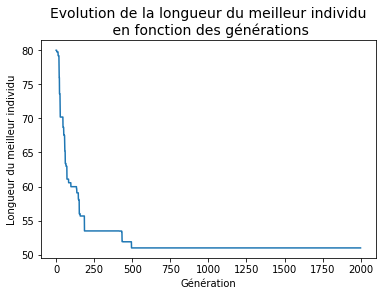

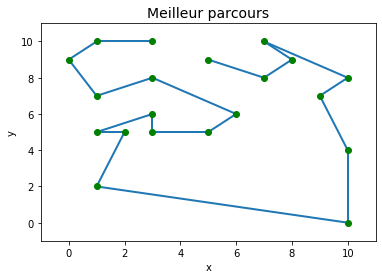

In [3]:
#Initialisation
ville_list = []
for i in range(20):
    ville = town(rd.randint(0,10),rd.randint(0,10), "ville" + str(i))
    ville_list.append(ville)

N = 1000 #Taille de la population
Nc = 4 #Nombre d'enfants par couple d'individus 
pc = 0.6 #Probabilité de croisement
pm = 0.02 #Probabilité de mutation
Ng = 2000 #Nombre de génération

#Création de la population
ma_population = population(ville_list)

#Lancement de l'algorithme
ma_population.main(N, Nc ,pc ,pm ,Ng)

Notre algorithme fonctionne, on obtient une solution à notre problème !

# 3. Algorithme optimisé

In [4]:
%load_ext Cython

<b>REMARQUE :</b><br>
Pour faciliter la lecture, dans la suite de ce notebook, les méthodes qui ont été ajoutées dans les classes sont précédées d'un tag #NEW.

## 3.1. Méthode "distance" de la classe "town"

### 3.1.1. Implémentation
On commence par s'intéresser à la classe "town". <br>
On utilise Cython pour accélérer le calcul des distances.

In [5]:
class town:
    """Représente une ville
        id : identifiant de la ville
        x : position selon l'axe des x
        y : position selon l'axe des y
        name : nom de la ville
    """
    
    def __init__(self, x, y, name = None):
        """Input : 
            x : position selon l'axe des x
            y : position selon l'axe des y
            name : nom de la ville
        """
        self.id = str(uuid.uuid4())[0:7]
        self.x = x
        self.y = y
        self.name = name
        
    def __str__(self):
        return "Id : " + self.id + "\n" + \
                "Coordonnées : (" + str(self.x) + ", " + str(self.y) + ")" + "\n" + \
                "Nom de la ville : " + self.name + "\n"
        
    def distance(self, town):
        """Calcule la distance entre deux villes"""
        return sqrt((self.x - town.x)**2 + (self.y - town.y)**2)
    
    #NEW
    def distance_cyt(self,town): 
        """Calcule la distance entre deux villes en utilisant cython"""
        return cdistance(self.x, self.y, town.x, town.y)

In [6]:
%%cython 
from libc.math cimport sqrt
cimport cython

#NEW
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef cdistance(float x1, float y1, float x2, float y2):
    """Calcule la distance entre les points (x1,y1) et (x2,y2)"""
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)

### 3.1.2. Tests
On compare les performances des deux calculs de distance.

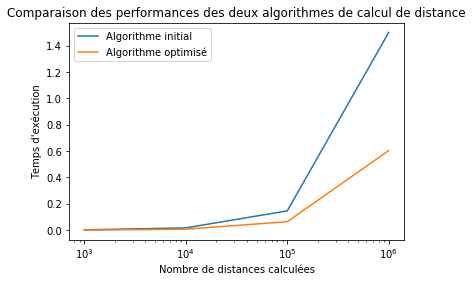

------------------
Résultats
------------------
Temps d'exécution avec l'algorithme initial : 1.50s
Temps d'exécution avec l'algorithme optimisé : 0.60s
Soit une accélération de 248.5%
pour 1000000 distances calculées.


In [7]:
#Initialisation
ville1 = town(0,0, "ville1")
ville2 = town(0,1, "ville2")

iteration_number_list = [10**i for i in range(3,7)]
initial_method = []
optimized_method = []

#Test
for iteration_number in iteration_number_list:
    #Initial
    begin = time.time()
    for _ in range(iteration_number):
        ville1.distance(ville2)
    initial_method.append(time.time() - begin)

    #Optimized
    begin = time.time()
    for _ in range(iteration_number):
        ville1.distance_cyt(ville2)
    optimized_method.append(time.time() - begin)

#Results
plt.plot(iteration_number_list,initial_method, label = "Algorithme initial")
plt.plot(iteration_number_list,optimized_method, label = "Algorithme optimisé")
plt.title("Comparaison des performances des deux algorithmes de calcul de distance")
plt.xlabel("Nombre de distances calculées")
plt.ylabel("Temps d'exécution")
plt.legend()
plt.xscale("log")
plt.show()

print("------------------")
print("Résultats")
print("------------------")
print("Temps d'exécution avec l'algorithme initial :", str("%.2f" % initial_method[-1]) + "s")
print("Temps d'exécution avec l'algorithme optimisé :", str("%.2f" % optimized_method[-1]) + "s")
print("Soit une accélération de", str("%.1f" % (initial_method[-1]/optimized_method[-1] * 100)) + "%")
print("pour", iteration_number, "distances calculées.")

On obtient de bons résultats : le temps passé à calculer ces distances est plus que divisé par 2.

## 3.2. Méthode "evaluate" de la classe "path"

On s'intéresse désormais à l'optimisation de la méthode "evaluate" de la classe "path".<br>

Remarquons que dans l'algorithme initial, cette méthode s'appuie sur l'utilisation de la méthode "distance" de la classe "town". Dans notre algorithme optimisé, ce n'est plus le cas.

### 3.2.1. Implémentation

In [8]:
class path:
    """Représente un parcours ordonné entre plusieurs villes
        id : identifiant
        town_map : liste des villes représentant le parcours
        length : longueur du parcours
    """
    
    def __init__(self, town_list, child = False):
        """Input : 
            town_list : liste des villes parcourues
            child : si child = False, la town_list est mélangée avant d'être assignée à la variable town_map
        """
        self.id = str(uuid.uuid4())[0:13]
        self.town_map = town_list.copy()
        if child == False:
            rd.shuffle(self.town_map)
        self.length = float('nan')
        
    def __str__(self):
        town_map_id = "\n".join([t.id for t in self.town_map])
        town_map_name = "\n".join([t.name for t in self.town_map])
        
        return "-------------------------------------" + "\n" + \
               "Id : " + self.id + "\n\n" + \
               "Parcours des villes (name)" + "\n" + town_map_name + "\n" + \
               "-------------------------------------"    

    def __len__(self):
        return len(self.town_map)
    
    def evaluate(self):
        """Calcule la longueur du parcours
        """
        length = self.town_map[0].distance(self.town_map[len(self) - 1]) #On initialise la longueur du parcours avec la distance entre le premier et le dernier élément
  
        for i in range(1, len(self)):
            length += self.town_map[i].distance(self.town_map[i - 1]) #On ajoute les autres distances
        
        self.length = length
        return length
    
    #NEW
    def evaluate_cyt(self,par = False):
        """Calcule la longueur du parcours en utilisant cython
            Input :
                par : parallélise le calcul si par = True
        """
        if not par:
            length = ccalculate_length(array.array('f', map(lambda town: town.x,self.town_map[:])),
                                       array.array('f', map(lambda town: town.y,self.town_map[:])))
        else:
            length = ccalculate_length_par(array.array('f', map(lambda town: town.x,self.town_map[:])),
                                           array.array('f', map(lambda town: town.y,self.town_map[:])),
                                           len(self.town_map))
            
        self.length = length
        return length 

In [9]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
from libc.math cimport sqrt
cimport cython
from cython.parallel cimport prange

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef cdistance(float x1, float y1, float x2, float y2):
    """Calcule la distance entre les points (x1,y1) et (x2,y2)"""
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)

#NEW
@cython.boundscheck(False)
@cython.wraparound(False)
def ccalculate_length(float[:] x, float[:] y):
    """Calcule la longueur du chemin passant par les villes de coordonnées (x[i],y[i])
        Input :
            x : tableau de la coordonnée x des villes
            y : tableau de la coordonnée y des villes
    """
    cdef int n_town = len(x)
    cdef float path_distance = cdistance(x[0],y[0],x[n_town-1],y[n_town-1])
    cdef i
    for i in range(n_town-1):
        path_distance += cdistance(x[i],y[i],x[i+1],y[i+1])
    return path_distance

#NEW
@cython.boundscheck(False)
@cython.wraparound(False)
def ccalculate_length_par(float[:] x, float[:] y, int n_town):
    """Calcule la longueur du chemin passant par les villes de coordonnées (x[i],y[i])
        Input :
            x : tableau de la coordonnée x des villes
            y : tableau de la coordonnée y des villes
            n_town : nombre de villes
    """
    cdef float distance[100] 
    cdef int i
    cdef float path_distance
    distance[n_town-1] = sqrt((x[0] - x[n_town-1])**2 + (y[0] - y[n_town-1])**2)
    for i in prange(n_town-1, nogil = True):
        distance[i] = sqrt((x[i] - x[i+1])**2 + (y[i] - y[i+1])**2)
    
    path_distance = 0
    for i in range(n_town):
        path_distance += distance[i]
    return path_distance

### 3.2.2. Tests

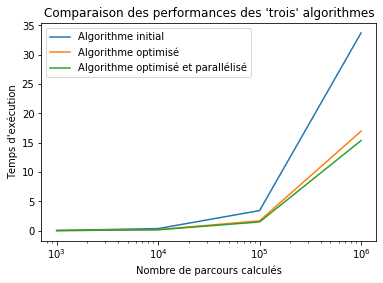

------------------
Résultats
------------------
Temps d'exécution avec l'algorithme initial : 33.73s

Temps d'exécution avec l'algorithme optimisé : 16.96s
Soit une accélération de 198.8%
pour 1000000 longueurs de chemins calculées.

Temps d'exécution avec l'algorithme optimisé et parallélisé : 15.37s
Soit une accélération de 219.4%
pour 1000000 longueurs de chemins calculées.


In [10]:
#Initialisation
ville_list = []
for i in range(20):
    ville = town(rd.randint(0,10),rd.randint(0,10), "ville" + str(i))
    ville_list.append(ville)

chemin = path(ville_list)

iteration_number_list = [10**i for i in range(3,7)]
initial_method = []
optimized_method = []
optimized_method_par = []

#Test
for iteration_number in iteration_number_list:
    #Initial
    begin = time.time()
    for _ in range(iteration_number):
        chemin.evaluate()
    initial_method.append(time.time() - begin)

    #Optimized
    begin = time.time()
    for _ in range(iteration_number):
        chemin.evaluate_cyt()
    optimized_method.append(time.time() - begin)

    #Optimized and parallelised
    begin = time.time()
    for _ in range(iteration_number):
        chemin.evaluate_cyt(par=True)
    optimized_method_par.append(time.time() - begin)

#Results
plt.plot(iteration_number_list,initial_method, label = "Algorithme initial")
plt.plot(iteration_number_list,optimized_method, label = "Algorithme optimisé")
plt.plot(iteration_number_list,optimized_method_par, label = "Algorithme optimisé et parallélisé")
plt.title("Comparaison des performances des 'trois' algorithmes")
plt.xlabel("Nombre de parcours calculés")
plt.ylabel("Temps d'exécution")
plt.legend()
plt.xscale("log")
plt.show()

print("------------------")
print("Résultats")
print("------------------")
print("Temps d'exécution avec l'algorithme initial :", str("%.2f" % initial_method[-1]) + "s")
print()
print("Temps d'exécution avec l'algorithme optimisé :", str("%.2f" % optimized_method[-1]) + "s")
print("Soit une accélération de", str("%.1f" % (initial_method[-1]/optimized_method[-1] * 100)) + "%")
print("pour", iteration_number, "longueurs de chemins calculées.")
print()
print("Temps d'exécution avec l'algorithme optimisé et parallélisé :", str("%.2f" % optimized_method_par[-1]) + "s")
print("Soit une accélération de", str("%.1f" % (initial_method[-1]/optimized_method_par[-1] * 100)) + "%")
print("pour", iteration_number, "longueurs de chemins calculées.")

Sur le calcul de longueur de chemins, notre optimisation porte également ses fruits.<br>
Paralléliser l'opération permet également d'obtenir un petit gain supplémentaire d'accélération.

## 3.3. Méthodes "evaluate" et "main" de la classe "population"

Ici, on s'intéresse à la mesure le gain de performances global des optimisations précédemment réalisées. Pour ce faire, on réalise quelques ajustements sur les méthodes "evaluate" et "main".

### 3.3.1. Implémentation

In [11]:
class population:
    """Représente une population d'individus (dans notre cas, ce sera des parcours)
        generation : numéro de la génération
        parent_list : liste des individus qui vont servir à créer la prochaine génération
        parent_fitness_list : fitness des parents (dans notre cas, il est dérivé de la longueur des parcours)
        best_parent : meilleur individu
        best_longueur : longueur du meilleur individu
        best_parent_length_history : historique des meilleurs longueurs au travers des générations
        children_list : liste des nouveaux individus
        gene_list : liste des gènes
        gene_number : nombre de gènes
    """
    
    def __init__(self, gene_list):
        self.generation = 0
        self.parent_list = []
        self.parent_fitness_list = []
        self.best_parent = None
        self.best_parent_length = sys.float_info.max
        self.best_parent_length_history = []
        self.children_list = []
        self.gene_list = gene_list
        self.gene_number = len(gene_list)
        
    def __len__(self):
        return len(self.parent_list)
        
    def create_generation_0(self, N):
        """Crée la génération 0
            Input :
                N : nombre d'individus
        """       
        for n in range(N):
            new_parent = path(self.gene_list)
            self.parent_list.append(new_parent)
            
    def evaluate(self):
        """Evalue la fitness de chaque individu de la population"""
        for i in self.parent_list:
            self.parent_fitness_list.append(i.evaluate())  
            
    #NEW
    def evaluate_cyt(self, par=False):
        """Evalue la fitness de chaque individu de la population"""
        for i in self.parent_list:
            self.parent_fitness_list.append(i.evaluate_cyt(par))  
            
    def get_best_parent(self):
        """Récupère l'ADN du meilleur parent ayant existé jusqu'à la génération actuelle"""
        for p in self.parent_list:
            if p.length < self.best_parent_length:
                self.best_parent_length = p.length
                self.best_parent = copy.copy(p)
                
        return self.best_parent_length
     
    def select(self, Ns):
        """Sélectionne les individus parents qui serviront à engendrer la génération suivante
            Input :
                Ns : nombre d'individus sélectionnés
        """
        self.parent_list = rd.choices(self.parent_list, weights = map(lambda x : 1/x, self.parent_fitness_list), k = int(Ns)) 
        
    
    def cross(self, Nc, pc):
        """Crée les enfants
            Input :
                pc : probabilité de croisement
                Nc : nombre d'enfants par couple de parents
        """
        for p1, p2 in zip(self.parent_list[0::2], self.parent_list[1::2]):           
            for _ in range(Nc):

                if rd.random() > pc:
                    #Cas 1 : pas de croisement, un des parents passe directement tel quel dans la génération suivante
                    if rd.random() > 0.5:
                        new_child = p1
                    else:
                        new_child = p2                       
                else:
                    #Cas 2: croisement
                    cut = rd.randint(1,self.gene_number - 1)
                    child_town_map_list = p1.town_map[0:cut]
                    a = 0                   
                    while len(child_town_map_list) < self.gene_number and a < self.gene_number :                        
                        if not p2.town_map[(cut + a) % len(p1)] in child_town_map_list :
                            child_town_map_list.append(p2.town_map[(cut + a) % len(p1)])
                        a += 1                     
                    new_child = path(child_town_map_list, child = True)
                    
                self.children_list.append(new_child)
    
    def mutate(self,pm):
        """Applique les mutations
            Input :
                pm : probabilité de mutation
        """
        for child in self.children_list:
            if rd.random() < pm:
                a1, a2 = rd.sample(range(len(self.gene_list)),k = 2)
                child.town_map[a1] , child.town_map[a2] = child.town_map[a2], child.town_map[a1]
                      
    def prepare_next_generation(self):
        """Prépare la génération suivante"""
        self.parent_list = self.children_list
        self.parent_fitness_list = []
        self.children_list = []    
        self.best_parent_length_history.append(self.best_parent_length)
        self.generation += 1
        
    def see_length_throught_generation(self):
        """Trace l'évolution de la meilleure longueur au travers des générations"""
        plt.plot(self.best_parent_length_history)
        plt.title("Evolution de la longueur du meilleur individu\n en fonction des générations", size = 14)
        plt.xlabel("Génération")
        plt.ylabel("Longueur du meilleur individu")
        
    def plot_best_path(self):        
        to_be_plot = []
        for i in range(len(self.gene_list)-1):
            to_be_plot.append([(self.best_parent.town_map[i].x, self.best_parent.town_map[i].y),
             (self.best_parent.town_map[i+1].x, self.best_parent.town_map[i+1].y)])
        lines = to_be_plot
        lc = mc.LineCollection(lines, linewidths=2)
        fig, ax = plt.subplots()
        ax.add_collection(lc)
        ax.autoscale()
        ax.margins(0.1)
        ax.set_title("Meilleur parcours", size = 14)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        for t in self.best_parent.town_map:
            ax.plot(t.x, t.y,"og")
        plt.show()
        
    def main(self, N, Nc, pc, pm, Ng, trace = True, plot = True):
        """Lance l'algorithme génétique
            Input:
                N : taille de la population
                Nc : nombre d'enfants par couple d'individus 
                pc : probabilité de croisement
                pm : probabilité de mutation
                Ng : nombre de génération                    
        """
        Ns = N / Nc #Nombre d'individus sélectionnés pour créer la génération suivante     
        assert Ns - floor(Ns) == 0
       
        self.create_generation_0(N)
        for g in range(Ng):
            self.evaluate()
            self.get_best_parent()
            self.select(Ns)
            self.cross(Nc,pc)
            self.mutate(pm)
            self.prepare_next_generation()
            if trace:
                if((g + 1) % 200 == 0):
                    print("Génération", g + 1 , "sur", Ng)
        if plot:
            self.see_length_throught_generation()
            self.plot_best_path()
    
    #NEW
    def main_cyt(self, N, Nc, pc, pm, Ng, trace = True, plot = True):
        """Lance l'algorithme génétique
            Input:
                N : taille de la population
                Nc : nombre d'enfants par couple d'individus 
                pc : probabilité de croisement
                pm : probabilité de mutation
                Ng : nombre de génération                    
        """
        Ns = N / Nc #Nombre d'individus sélectionnés pour créer la génération suivante     
        assert Ns - floor(Ns) == 0
        assert self.gene_number <= 100
       
        self.create_generation_0(N)
        for g in range(Ng):
            self.evaluate_cyt(par=True)
            self.get_best_parent()
            self.select(Ns)
            self.cross(Nc,pc)
            self.mutate(pm)
            self.prepare_next_generation()
            if trace:
                if((g + 1) % 200 == 0):
                    print("Génération", g + 1 , "sur", Ng)
        if plot:
            self.see_length_throught_generation()
            self.plot_best_path()

### 3.3.2. Tests

In [12]:
#Initialisation
ville_list = []
for i in range(20):
    ville = town(rd.randint(0,10),rd.randint(0,10), "ville" + str(i))
    ville_list.append(ville)

N = 1000 #Taille de la population
Nc = 4 #Nombre d'enfants par couple d'individus 
pc = 0.6 #Probabilité de croisement
pm = 0.02 #Probabilité de mutation
Ng = 2000 #Nombre de génération

ma_population = population(ville_list) #Création de la population

initial_method = []
optimized_method_par = []

#Test
#Initial
print("--------------------")
print("Algorithme initial")
print("--------------------")
begin = time.time()
ma_population.main(N, Nc, pc, pm, Ng, plot = False)
initial_method.append(time.time() - begin)
print("")

#Optimized
print("--------------------")
print("Algorithme optimisé")
print("--------------------")
begin = time.time()
ma_population.main_cyt(N, Nc, pc, pm, Ng, plot = False)
optimized_method_par.append(time.time() - begin)
print("")

#Results
print("------------------")
print("Résultats")
print("------------------")
print("Temps d'exécution avec l'algorithme initial :", str("%.2f" % initial_method[0]) + "s")
print("Temps d'exécution avec l'algorithme optimisé et parallélisé :", str("%.2f" % optimized_method_par[0]) + "s")
print("Soit une accélération de", str("%.1f" % (initial_method[0]/optimized_method_par[0] * 100)) + "%")

--------------------
Algorithme initial
--------------------
Génération 200 sur 2000
Génération 400 sur 2000
Génération 600 sur 2000
Génération 800 sur 2000
Génération 1000 sur 2000
Génération 1200 sur 2000
Génération 1400 sur 2000
Génération 1600 sur 2000
Génération 1800 sur 2000
Génération 2000 sur 2000

--------------------
Algorithme optimisé
--------------------
Génération 200 sur 2000
Génération 400 sur 2000
Génération 600 sur 2000
Génération 800 sur 2000
Génération 1000 sur 2000
Génération 1200 sur 2000
Génération 1400 sur 2000
Génération 1600 sur 2000
Génération 1800 sur 2000
Génération 2000 sur 2000

------------------
Résultats
------------------
Temps d'exécution avec l'algorithme initial : 57.45s
Temps d'exécution avec l'algorithme optimisé et parallélisé : 35.96s
Soit une accélération de 159.8%


L'optimisation des méthodes de calculs de distance nous permet donc de réduire notre temps d'exécution global de plus de 30%.

# 4. Conclusion

Ce projet nous a permis de montrer qu'en utilisant savamment Cython, on pouvait réduire diviser par plus de 2 les temps d'exécution de certaines méthodes. Ce gain local nous permet de réduire le temps d'exécution global de notre algorithme de 30%.

Ce projet a été également, pour nous, l'occasion d'apprendre à coder des classes et des méthodes en Python.

Avec plus de temps, nous aurions pu également nous intéresser à l'optimisation des méthodes population.cross() et population.mutate() où on peut raisonnablement s'attendre à des gains substantiels.

Une autre façon d'optimiser les temps de calcul serait de s'intéresser :
* aux paramètres de l'algorithme. <br>
En ajustant les probabilités et les quantités, on pourrait éventuellement optimiser la convergence vers une bonne solution.


* au calcul de fitness.<br>
Des fonctions de calcul de fitness plus complexes pourraient être utilisées pour favoriser les bons individus.


* au mode de sélection des individus.<br>
Sélection par rang, séléction par tournoi... sont d'autres possibilités de sélection à envisager.


* à la parallélisation de l'algorithme dans son ensemble.<br>
On pourrait, par exemple, imaginer diviser la population initiale en 4 groupes, les faire évoluer séparemment sur 4 processeurs. Toutes les 100 générations, on les réunirait. On reformerait alors 4 nouveaux groupes, les ferait évoluer séparemment sur les 4 processeurs... Cette méthode aurait l'avantage de paralléliser toutes les étapes de l'algorithme.